In [1]:
from ragraph.io.esl import from_esl
graph = from_esl(["./esl"])

import raesl.plot
figure = raesl.plot.mdm(
    graph,
    node_kinds=["component"],
)
figure.write_image("figures/dsm_components.svg")
figure.show()

from utils import set_edge_weights, annotate_variable_type
annotate_variable_type(graph)

In [2]:
print(graph.as_dict())

{'nodes': {'real': {'name': 'real', 'parent': None, 'children': [], 'is_bus': False, 'kind': 'variable_type', 'labels': ['default'], 'weights': {'default': 1}, 'annotations': {'esl_info': {'units': [], 'domain': None, 'comments': [], 'tagged_comments': defaultdict(<class 'list'>, {})}}}, 'integer': {'name': 'integer', 'parent': None, 'children': [], 'is_bus': False, 'kind': 'variable_type', 'labels': ['default'], 'weights': {'default': 1}, 'annotations': {'esl_info': {'units': [], 'domain': None, 'comments': [], 'tagged_comments': defaultdict(<class 'list'>, {})}}}, 'string': {'name': 'string', 'parent': None, 'children': [], 'is_bus': False, 'kind': 'variable_type', 'labels': ['default'], 'weights': {'default': 1}, 'annotations': {'esl_info': {'units': [], 'domain': None, 'comments': [], 'tagged_comments': defaultdict(<class 'list'>, {})}}}, 'boolean': {'name': 'boolean', 'parent': None, 'children': [], 'is_bus': False, 'kind': 'variable_type', 'labels': ['default'], 'weights': {'defa

In [2]:
import networkx as nx
from pyvis.network import Network
import os

# Use your graph dictionary
graph_data = graph.as_dict()

def create_site_structure(base_dir="site"):
    lib_dir = os.path.join(base_dir, "lib")
    if not os.path.exists(base_dir): os.makedirs(base_dir)
    if not os.path.exists(lib_dir): os.makedirs(lib_dir)

def visualize_complete_dashboard(data, output_dir="site", filename="index.html"):
    create_site_structure(output_dir)
    full_path = os.path.join(output_dir, filename)

    # ---------------------------------------------------------
    # 1. PARSE & BUILD LOGIC GRAPH
    # ---------------------------------------------------------
    RawG = nx.DiGraph()
    for node_id, node_attrs in data['nodes'].items():
        RawG.add_node(node_id, **node_attrs)
    for edge_id, edge_attrs in data['edges'].items():
        attrs = edge_attrs.copy()
        attrs.pop('source', None)
        attrs.pop('target', None)
        RawG.add_edge(edge_attrs['source'], edge_attrs['target'], **attrs)

    CalcG = nx.DiGraph()
    variable_nodes = set()
    glue_nodes = []

    for n, attrs in RawG.nodes(data=True):
        if attrs.get('kind') == 'variable':
            variable_nodes.add(n)
            CalcG.add_node(n)
        else:
            glue_nodes.append(n)

    def is_flow(attrs):
        reason = attrs.get('annotations', {}).get('esl_info', {}).get('reason', {})
        if 'relation_specifications' in reason: return True
        if 'design_specifications' in reason: return False
        return True

    for u, v, attrs in RawG.edges(data=True):
        if u in variable_nodes and v in variable_nodes and is_flow(attrs):
            CalcG.add_edge(u, v)

    for glue in glue_nodes:
        if RawG.nodes[glue].get('kind') == 'design_spec': continue 
        preds = [p for p in RawG.predecessors(glue) if p in variable_nodes]
        succs = [s for s in RawG.successors(glue) if s in variable_nodes]
        for p in preds:
            for s in succs:
                if not CalcG.has_edge(p, s): CalcG.add_edge(p, s)

    # ---------------------------------------------------------
    # 2. DETECT FEEDBACK LOOPS
    # ---------------------------------------------------------
    feedback_edges = set()
    try:
        cycles = list(nx.simple_cycles(CalcG))
        for cycle in cycles:
            for i in range(len(cycle)):
                u, v = cycle[i], cycle[(i + 1) % len(cycle)]
                feedback_edges.add((u, v))
    except Exception:
        pass

    # ---------------------------------------------------------
    # 3. CLASSIFY NODES
    # ---------------------------------------------------------
    inputs = set()
    outputs = set()
    intermediates = set()

    for n in CalcG.nodes():
        in_d = CalcG.in_degree(n)
        out_d = CalcG.out_degree(n)
        if in_d == 0 and out_d == 0: pass
        elif in_d == 0: inputs.add(n)
        elif out_d == 0: outputs.add(n)
        else: intermediates.add(n)

    inter_outputs = set()
    for n in list(intermediates):
        succs = list(CalcG.successors(n))
        if succs and all(s in outputs for s in succs):
            inter_outputs.add(n)
            intermediates.remove(n)

    # ---------------------------------------------------------
    # 4. CALCULATE DEPENDENCY STATS (BY TYPE)
    # ---------------------------------------------------------
    node_stats = {}
    
    def get_node_type(node_id):
        # Returns '2d', '3d', or 'both'
        attrs = RawG.nodes[node_id]
        # Check explicit annotation first
        if 'type' in attrs.get('annotations', {}):
            return str(attrs['annotations']['type']).lower()
            
        # Check tagged comments fallback
        tags = attrs.get('annotations', {}).get('esl_info', {}).get('tagged_comments', {})
        if 'type' in tags and tags['type']:
            return str(tags['type'][0]).lower()
            
        return 'both' # Default

    for n in CalcG.nodes():
        ancestors = nx.ancestors(CalcG, n)
        root_inputs = {a for a in ancestors if a in inputs}
        if n in inputs: root_inputs.add(n)
        
        count_2d = 0
        count_3d = 0
        count_both = 0
        
        for inp in root_inputs:
            t = get_node_type(inp)
            if t == '2d': count_2d += 1
            elif t == '3d': count_3d += 1
            else: count_both += 1
            
        node_stats[n] = {
            'count_2d': count_2d, 
            'count_3d': count_3d, 
            'count_both': count_both, 
            'total': len(root_inputs)
        }

    # ---------------------------------------------------------
    # 5. BUILD VISUAL GRAPH
    # ---------------------------------------------------------
    VisG = nx.DiGraph()
    
    # Colors
    C_INPUT      = "#3366FF"  # Blue
    C_INTER      = "#FFCC00"  # Yellow
    C_INTER_OUT  = "#FF0000"  # Red
    C_OUTPUT     = "#33CC33"  # Green
    C_ISO        = "#AAAAAA"  # Grey
    C_FEEDBACK   = "#FF00FF"  # Magenta

    for n in variable_nodes:
        attrs = RawG.nodes[n]
        label = attrs.get('name').split('.')[-1]
        units = attrs.get('annotations', {}).get('esl_info', {}).get('units', 'N/A')
        
        node_type = get_node_type(n)
        
        # Determine Group & Color
        group_id = 'Isolated'
        color = C_ISO
        size = 20
        
        # Default Shape
        shape = 'dot' 

        if n in inputs:
            group_id = 'Input'
            color = C_INPUT
            size = 30
            # Shape logic applies strictly to inputs (or based on type if desired globally)
            if node_type == '2d': shape = 'diamond'
            elif node_type == '3d': shape = 'triangle'
            else: shape = 'dot'
        elif n in outputs:
            group_id = 'Output'
            color = C_OUTPUT
            size = 30
        elif n in inter_outputs:
            group_id = 'Intermediate Output'
            color = C_INTER_OUT
            size = 25
        elif n in intermediates:
            group_id = 'Intermediate'
            color = C_INTER
            size = 20

        stats = node_stats.get(n, {'count_2d':0, 'count_3d':0, 'count_both':0, 'total':0})
        title = f"<b>{label}</b><br>Group: {group_id}<br>Type: {node_type}<br>Unit: {units}"
        
        VisG.add_node(n, label=label, title=title, 
                      color=color, shape=shape, size=size, 
                      borderWidth=2, font={'color': 'white', 'strokeWidth': 4, 'strokeColor': 'black'},
                      # Embed data for JS
                      group_id=group_id, node_type=node_type,
                      stat_2d=stats['count_2d'], stat_3d=stats['count_3d'], 
                      stat_both=stats['count_both'], stat_total=stats['total'])

    for u, v in CalcG.edges():
        if (u, v) in feedback_edges:
            VisG.add_edge(u, v, color=C_FEEDBACK, width=3, arrows='to')
        else:
            VisG.add_edge(u, v, color='#888888', width=1, arrows='to')

    # ---------------------------------------------------------
    # 6. RENDER
    # ---------------------------------------------------------
    net = Network(height="90vh", width="100%", bgcolor="#222222", font_color="white", select_menu=False, filter_menu=False)
    net.from_nx(VisG)
    
    net.set_options("""
    var options = {
      "physics": {
        "forceAtlas2Based": {
          "gravitationalConstant": -80,
          "centralGravity": 0.005,
          "springLength": 80,
          "springConstant": 0.08,
          "damping": 0.4,
          "avoidOverlap": 0.8
        },
        "maxVelocity": 40,
        "minVelocity": 0.1,
        "solver": "forceAtlas2Based"
      },
      "interaction": {
        "hover": true,
        "multiselect": true,
        "navigationButtons": true
      }
    }
    """)

    net.save_graph(full_path)
    
    node_options = ""
    sorted_nodes = sorted(list(VisG.nodes(data=True)), key=lambda x: x[1]['label'])
    for n_id, attrs in sorted_nodes:
        node_options += f'<option value="{n_id}">{attrs["label"]}</option>\n'

    inject_dashboard_logic(full_path, node_options)
    print(f"Visualization saved to: {full_path}")

def inject_dashboard_logic(filepath, node_options):
    head_code = """
    <link href="https://cdn.jsdelivr.net/npm/tom-select@2.2.2/dist/css/tom-select.css" rel="stylesheet">
    <script src="https://cdn.jsdelivr.net/npm/tom-select@2.2.2/dist/js/tom-select.complete.min.js"></script>
    <style>
        body { margin: 0; padding: 0; overflow: hidden; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; }
        .ts-control { background-color: #333; color: white; border: 1px solid #555; }
        .ts-dropdown { background-color: #333; color: white; border: 1px solid #555; }
        .ts-dropdown .option { color: white; }
        .ts-dropdown .active { background-color: #555; color: white; }
        .ts-control input { color: white; }

        .card {
            background: rgba(50,50,50,0.95); color: white; 
            padding: 15px; border-radius: 8px; border: 1px solid #555; 
            box-shadow: 0 4px 8px rgba(0,0,0,0.4); font-size: 0.9em;
        }
        h4 { margin: 0 0 10px 0; border-bottom: 1px solid #555; padding-bottom: 8px; font-size: 1em; text-transform: uppercase; letter-spacing: 0.5px; }

        #legend {
            position: absolute; bottom: 15px; left: 50%; transform: translateX(-50%);
            z-index: 1000; background: rgba(50,50,50,0.95);
            padding: 10px 25px; border-radius: 50px; border: 1px solid #555;
            display: flex; gap: 20px; align_items: center; box-shadow: 0 4px 8px rgba(0,0,0,0.4);
        }
        .legend-item { display: flex; align_items: center; gap: 8px; }
        .shape { display: inline-block; }
        .circle { width: 12px; height: 12px; border-radius: 50%; }
        .diamond { width: 10px; height: 10px; background: #3366FF; transform: rotate(45deg); border: 2px solid white; }
        .triangle { width: 0; height: 0; border-left: 6px solid transparent; border-right: 6px solid transparent; border-top: 10px solid #3366FF; }
        .line { width: 25px; height: 2px; background: #888888; }
        .feedback { height: 4px; background: #FF00FF; }
        
        .stat-row { display: flex; justify-content: space-between; margin-bottom: 5px; }
        .stat-val { font-weight: bold; }
    </style>
    """
    
    body_ui = f"""
    <div style="position: absolute; top: 15px; left: 50%; transform: translateX(-50%); z-index: 1000; width: 350px;">
        <select id="node-search" placeholder="Search variables..."><option value="">Search...</option>{node_options}</select>
    </div>

    <div class="card" style="position: absolute; top: 15px; left: 15px; z-index: 999; width: 220px;">
        <h4>Filters</h4>
        <label style="color: #ccc;">Variable Group:</label>
        <select id="groupFilter" onchange="applyFilters()" style="width: 100%; margin: 5px 0 15px 0; background: #333; color: white; border: 1px solid #555; padding: 4px;">
            <option value="All">Show All</option>
            <option value="Input">Inputs</option>
            <option value="Intermediate">Intermediate</option>
            <option value="Intermediate Output">Intermediate Output</option>
            <option value="Output">Outputs</option>
        </select>
        <label style="color: #ccc;">Input Type:</label>
        <select id="typeFilter" onchange="applyFilters()" style="width: 100%; margin: 5px 0 5px 0; background: #333; color: white; border: 1px solid #555; padding: 4px;">
            <option value="All">Show All</option>
            <option value="2d">2D (Diamonds)</option>
            <option value="3d">3D (Triangles)</option>
            <option value="both">Both (Dots)</option>
        </select>
        <button onclick="resetAll()" style="width:100%; margin-top:15px; padding: 6px; background: #555; color: white; border: none; border-radius: 4px; cursor: pointer;">Reset View</button>
    </div>

    <div id="selection-card" class="card" style="position: absolute; top: 15px; right: 15px; z-index: 999; width: 250px; display: none;">
        <h4>Selection Details</h4>
        <div id="sel-name" style="font-weight: bold; margin-bottom: 10px; color: #4DA3FF; word-break: break-all;"></div>
        
        <div style="border-top: 1px solid #555; padding-top: 10px;">
            <div style="font-size: 0.8em; text-transform: uppercase; color: #aaa; margin-bottom: 5px;">Upstream Inputs</div>
            <div class="stat-row">
                <span><span style="color:#3366FF">◆</span> 2D:</span>
                <span id="stat-2d" class="stat-val">0</span>
            </div>
            <div class="stat-row">
                <span><span style="color:#3366FF">▼</span> 3D:</span>
                <span id="stat-3d" class="stat-val">0</span>
            </div>
            <div class="stat-row">
                <span><span style="color:#3366FF">●</span> Both:</span>
                <span id="stat-both" class="stat-val">0</span>
            </div>
            <div class="stat-row" style="border-top: 1px solid #444; margin-top: 5px; padding-top: 5px;">
                <span>Total Inputs:</span>
                <span id="stat-total" class="stat-val">0</span>
            </div>
        </div>
    </div>

    <div id="legend">
        <div class="legend-item"><div class="shape diamond"></div><span>2D Input</span></div>
        <div class="legend-item"><div class="shape triangle"></div><span>3D Input</span></div>
        <div class="legend-item"><div class="shape circle" style="background:#3366FF;"></div><span>Both/Input</span></div>
        <div class="legend-item"><div class="shape circle" style="background:#FFCC00;"></div><span>Intermediate</span></div>
        <div class="legend-item"><div class="shape circle" style="background:#FF0000;"></div><span>Interm. Output</span></div>
        <div class="legend-item"><div class="shape circle" style="background:#33CC33;"></div><span>Final Output</span></div>
        <div class="legend-item"><div class="shape line feedback"></div><span>Feedback Loop</span></div>
    </div>
    """

    js_logic = """
    <script type="text/javascript">
        var searchSelect = new TomSelect("#node-search",{
            create: false, sortField: {field: "text", direction: "asc"},
            onChange: function(value) {
                if (value) {
                    selectNode(value);
                }
            }
        });

        var allNodeIds = nodes.getIds();
        
        function selectNode(nodeId) {
            highlightUpstream(nodeId);
            showDetails(nodeId);
            network.selectNodes([nodeId]);
            network.focus(nodeId, {scale: 1.2, animation: true});
        }

        function showDetails(nodeId) {
            var node = nodes.get(nodeId);
            if (!node) return;
            document.getElementById('sel-name').innerText = node.label;
            document.getElementById('stat-2d').innerText = node.stat_2d;
            document.getElementById('stat-3d').innerText = node.stat_3d;
            document.getElementById('stat-both').innerText = node.stat_both;
            document.getElementById('stat-total').innerText = node.stat_total;
            document.getElementById('selection-card').style.display = 'block';
        }

        function applyFilters() {
            var groupVal = document.getElementById('groupFilter').value;
            var typeVal = document.getElementById('typeFilter').value;
            var updateArray = [];
            document.getElementById('selection-card').style.display = 'none';

            allNodeIds.forEach(id => {
                var node = nodes.get(id);
                var show = true;
                if (groupVal !== 'All' && node.group_id !== groupVal) show = false;
                
                if (node.group_id === 'Input' && typeVal !== 'All') {
                    if (node.node_type !== typeVal) show = false;
                }
                updateArray.push({id: id, hidden: !show, opacity: 1});
            });
            nodes.update(updateArray);
            
            var edgeUpdate = [];
            for (edgeId in allEdges) { edgeUpdate.push({id: edgeId, opacity: 1, hidden: false}); }
            edges.update(edgeUpdate);
        }

        function resetAll() {
            document.getElementById('groupFilter').value = 'All';
            document.getElementById('typeFilter').value = 'All';
            searchSelect.clear();
            document.getElementById('selection-card').style.display = 'none';
            applyFilters();
        }

        function highlightUpstream(selectedId) {
            var connectedNodes = new Set();
            
            function getParents(nodeId) {
                connectedNodes.add(nodeId);
                var parentEdges = network.getConnectedEdges(nodeId).filter(e => {
                    var edge = edges.get(e);
                    return edge.to === nodeId; 
                });
                parentEdges.forEach(e => {
                    var edgeObj = edges.get(e);
                    if (!connectedNodes.has(edgeObj.from)) {
                        getParents(edgeObj.from);
                    }
                });
            }

            getParents(selectedId);

            var nodeUpdate = [];
            allNodeIds.forEach(id => {
                if (connectedNodes.has(id)) {
                    nodeUpdate.push({id: id, opacity: 1, hidden: false});
                } else {
                    nodeUpdate.push({id: id, opacity: 0.1});
                }
            });
            nodes.update(nodeUpdate);
            
            var edgeUpdate = [];
            var allEdgeIds = edges.getIds();
            allEdgeIds.forEach(id => {
                var edge = edges.get(id);
                if (connectedNodes.has(edge.from) && connectedNodes.has(edge.to)) {
                    edgeUpdate.push({id: id, opacity: 1, hidden: false});
                } else {
                    edgeUpdate.push({id: id, opacity: 0.05});
                }
            });
            edges.update(edgeUpdate);
        }

        network.on("click", function (params) {
            if (params.nodes.length > 0) {
                var nodeId = params.nodes[0];
                selectNode(nodeId);
                searchSelect.setValue(nodeId, true); 
            } else {
                applyFilters();
                searchSelect.clear();
            }
        });
    </script>
    """

    with open(filepath, "r") as f:
        content = f.read()

    if "</head>" in content:
        content = content.replace("</head>", head_code + "\n</head>")
    if "<body>" in content:
        content = content.replace("<body>", "<body>\n" + body_ui)
    if "</body>" in content:
        content = content.replace("</body>", js_logic + "\n</body>")
        
    with open(filepath, "w") as f:
        f.write(content)

# Run
visualize_complete_dashboard(graph_data)

Visualization saved to: site/index.html


In [10]:
import ragraph.plot

figure = raesl.plot.mdm(
    graph,
    node_kinds=["component", "variable"],
    depth=2,
    style=raesl.plot.Style(
        ragraph=ragraph.plot.Style(
            piemap=dict(
                display="weights",
                mode= "relative",
                fields=["weight"]
            ),
        )
    )
)

figure.write_image("figures/mdm_weights.svg")
figure.show()

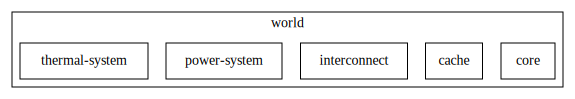

In [11]:
digraph = raesl.plot.functional_dependency_diagram(
    graph,
    root=graph["world"],
    levels=2,
)
digraph

In [12]:
figure = raesl.plot.mdm(
    graph,
    # node_kinds=["component", "variable", "function_spec", "design_spec", "relation_spec"],
    # edge_kinds=["functional_dependency", "mapping_dependency"],
    depth=2,
)
figure.write_image("figures/mdm.svg")
# figure.show()

In [13]:
# from raesl.plot.view_funcs import multi_domain
# from ragraph.analysis import cluster

# nodes, edges = multi_domain(
#     graph,
#     depth=4
# )

# relations = [n for n in nodes if n.kind == "relation_spec"]
# variables = [n for n in nodes if n.kind == "variable"]
# components = [n for n in nodes if n.kind == "component"]

# # Cluster components
# cluster.tarjans_scc(
#     graph=graph,
#     leafs = relations+variables,
# )

# # Reloaded MDM based on clustered graph.
# figure = raesl.plot.mdm(
#     graph,
#     # node_kinds=["component", "variable", "function_spec", "design_spec", "relation_spec"],
#     # edge_kinds=["functional_dependency", "mapping_dependency"],
#     depth=2,
# )
# figure.write_image("figures/mdm_clustered.svg")
# # figure.show()

In [14]:
from ragraph.analysis import sequence
import ragraph.plot

from raesl.plot.view_funcs import multi_domain

nodes, edges = multi_domain(
    graph,
    depth=4
)

relations = [n for n in nodes if n.kind == "relation_spec"]
variables = [n for n in nodes if n.kind == "variable"]
components = [n for n in nodes if n.kind == "component"]


_, _, sequenced_functions = sequence.utils.branchsort(algo=sequence.scc_tearing, graph=graph, algo_args=dict(inf=1, dep=1, mu=3), inplace=True, nodes=relations+variables, edge_weights=graph.weights)

# Reload figure based on sequence.
figure = ragraph.plot.mdm(
    leafs = components + sequenced_functions,
    edges = edges,
    style= ragraph.plot.Style(
        piemap=dict(
            display="weights",
            mode= "relative",
            fields=["weight"]
        ),
    )
)

figure.write_image("figures/mdm_sequenced.svg")
figure.show()